# What is the energy distribution of FRB 121102 bursts?

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as pl
from scipy.optimize import curve_fit
from scipy.misc import factorial
import astropy.cosmology as cosmo
import astropy.units as u
import multiprocessing
from contextlib import closing

# optimization produces lots of warning that can be ignored
import warnings
warnings.filterwarnings('ignore')

## Some useful functions and data

In [3]:
# reference values and functions
en_s = lambda ld, s: s*1e-23 * (4*np.pi*ld**2) * 5e-3 * 1.024e9 # VLA S-band energy in erg, s in Jy, ld in cm
plaw = lambda x, alpha, a: a*(x/x[0])**alpha  # given array x, return powerlaw relative to first entry

co = cosmo.Planck15
ld0 = co.luminosity_distance(0.193)

In [4]:
fluence_aom = np.array([0.1, 0.1, 0.1, 0.2, 0.09, 0.06, 0.06, 0.9, 0.3, 0.2, 1.0]) # spitler et al 2014, 2016
fluence_aop = np.array([0.09])  # scholz et al 2016
fluence_gbt = np.array([0.2, 0.4, 0.2, 0.08, 0.6])  # scholz et al 2016

bw_aom = 322e6
bw_gbt = 600e6
bw_aop = 600e6

# both were pointed on axis, more or less
beam_aom = 1
beam_gbt = 1

en_aom = np.sort(beam_aom * fluence_aom * 1e-3 * bw_aom * 1e-23 * (4*np.pi*ld0.to(u.cm).value**2))
en_aop = np.sort(fluence_aop * 1e-3 * bw_aop * 1e-23 * (4*np.pi*ld0.to(u.cm).value**2))
en_gbt = np.sort(beam_gbt * fluence_gbt * 1e-3 * bw_gbt * 1e-23 * (4*np.pi*ld0.to(u.cm).value**2))

In [5]:
#en0 = np.array([1.5, 12, 0.6, 0.4, 2.1, 0.2, 0.4, 0.6, 0.6])* 1e39  # first draft mult by full S-band width
#en0 = np.array([7.1, 56, 5.5, 1.7, 11, 1.0, 3.4, 2.6, 3.7])*1e38  # using burst widths
en0 = np.array([11.5, 97.5, 7.2, 3.1, 34.0, 3.7, 10.0, 6.9, 11.6])*1e38 # using burst widths and phasing at best location
en0.sort()
cnt = np.arange(1,len(en0)+1)[::-1]

Powerlaw slope -1.0 and amplitude 10.0 (at L=4.0690791232e+38)
Cumulative powerlaw slope -0.644204483908 and amplitude 9.36998515143 (at L=3.1e+38)


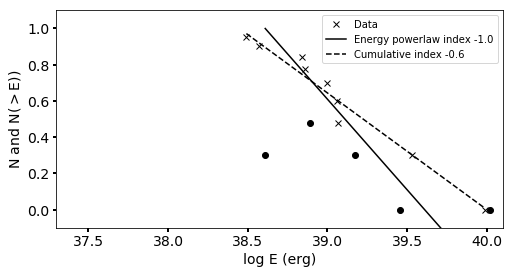

In [6]:
# chisq minimization

fig = pl.figure(figsize=(8,4))
ax = fig.add_subplot(111)
pl.plot(np.log10(en0), np.log10(cnt), 'kx', label='Data')

bins = np.logspace(np.log10(0.9*en0.min()), np.log10(10*en0.max()), 10)
#bins = np.linspace(0.9*en0.min(), 1.1*en0.max(), 10)
cnt0, edg0 = pl.histogram(en0, bins=bins)
bins = np.array([(edg0[i+1] + edg0[i])/2. for i in range(len(edg0)-1)])
poptc, pcovc = curve_fit(plaw, bins, cnt0, sigma=np.sqrt(cnt0), p0=(-1, 10))
print('Powerlaw slope {0} and amplitude {1} (at L={2})'.format(poptc[0], poptc[1], bins[0]))
pl.plot(np.log10(bins), np.log10(cnt0), 'ko')
pl.plot(np.log10(bins), np.log10(plaw(bins, *poptc)), 'k-', label='Energy powerlaw index {0:.1f}'.format(poptc[0]))

popt0, pcov0 = curve_fit(plaw, en0, cnt, sigma=np.sqrt(cnt), p0=(-1, 10))
print('Cumulative powerlaw slope {0} and amplitude {1} (at L={2})'.format(popt0[0], popt0[1], en0[0]))
pl.plot(np.log10(en0), np.log10(plaw(en0, *popt0)), 'k--', label='Cumulative index {0:.1f}'.format(popt0[0]))

pl.xlabel('log E (erg)', fontsize=14)
pl.ylabel('N and N($>$E))', fontsize=14)
pl.xlim(37.3, 40.1)
pl.ylim(-0.1, 1.1)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=2, color='k')
ax.yaxis.set_tick_params(width=2, color='k')
pl.legend()

In [7]:
cnt_aom = np.arange(1,len(en_aom)+1)[::-1]
cnt_gbt = np.arange(1,len(en_gbt)+1)[::-1]
en_all = np.sort(np.concatenate( (en_aom, en_gbt, en_aop, en0) ))
cnt_all = np.arange(1, len(en_all) + 1)[::-1]

# gbt pointed at repeater so flux is ok
# ao off, but less than factor of 2

# emphasize obs not at same epoch

time_gbt = 15.3 # hrs
time_vla = 27. # fall 2016 campaign
time_aom = 4. # Spitler et al

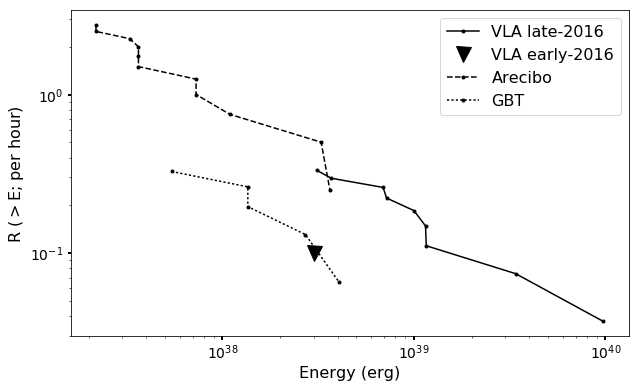

In [8]:
fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(111)
pl.plot(en0, cnt/time_vla, 'k.-', label='VLA late-2016')
pl.plot([3e38], [0.1], 'kv', ms=15, label='VLA early-2016')
pl.plot(en_aom, cnt_aom/time_aom, 'k.--', label='Arecibo')
pl.plot(en_gbt, cnt_gbt/time_gbt, 'k.:', label='GBT')
#pl.plot(en_all, cnt_all, 'k.-', size=30)
pl.loglog()
#pl.xlim(elim, 1.1e40)
#pl.ylim(0.5, 20)
pl.xlabel('Energy (erg)', fontsize=16)
pl.ylabel('R ($>$E; per hour)', fontsize=16)
pl.legend(fontsize=16)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=2, color='k')
ax.yaxis.set_tick_params(width=2, color='k')
fig.savefig('energy_disn.pdf', format='pdf')

(-1.1155778894472361, -0.70351758793969843, -0.4120603015075377)
(0.15170351758793971, 0.30240703517587941, 0.57367336683417081)
(2, 9)


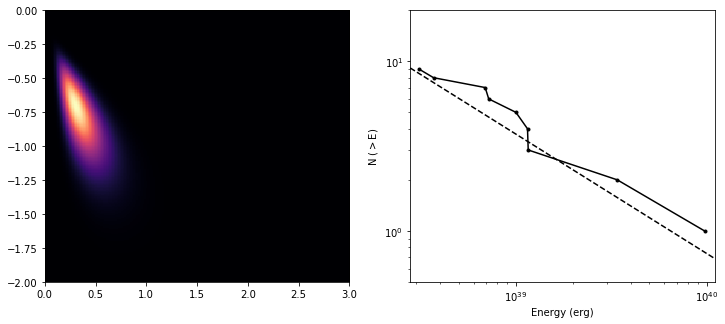

In [9]:
# probabilistic modeling

rate = lambda e, elim, alpha, a: a*(e/elim)**alpha

def like(pars, e, elim, c):
    alpha, a0 = pars
    lam = rate(e, elim, alpha, a0)
    return (lam**c) * np.exp(-lam)/factorial(c)

alphas = np.linspace(-2, 0, 200)
a0s = np.linspace(1e-3, 3, 200)
earr = np.zeros(shape=(len(alphas), len(a0s)))
extent = (a0s[0], a0s[-1], alphas[0], alphas[-1])

elim = 0.9*en0.min()
ens = en0
cnts = cnt

engrid = np.logspace(np.log10(elim), 80, 2000)
cntgrid = np.zeros(len(engrid), dtype=int)

for en in ens:
    i = np.where(engrid > en)[0][0]
    cntgrid[i] += 1

for i in range(len(alphas)):
    for j in range(len(a0s)):
        earr[i,j] = np.prod(like((alphas[i], a0s[j]), engrid, elim, cntgrid))


# 95% bounds
palpha, pa0 = np.where(earr == earr.max())
walphas, wa0s = np.where(earr > 0.32*earr.max())
print(alphas[walphas].min(), alphas[palpha[0]], alphas[walphas].max())
print(a0s[wa0s].min(), a0s[pa0[0]], a0s[wa0s].max())
print(cntgrid.max(), cntgrid.sum())
popt1 = (alphas[palpha[0]], a0s[pa0[0]])

fig = pl.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pl.imshow(earr, interpolation='nearest', origin='bottom', cmap='magma',
          aspect='auto', extent=extent)

ax = fig.add_subplot(122)
pl.plot(ens, cnts, 'k.-')
pl.plot(engrid, rate(engrid, elim, alphas[palpha[0]], a0s[pa0[0]])[::-1].cumsum()[::-1], 'k--')
pl.loglog()
pl.xlim(elim, 1.1e40)
pl.ylim(0.5, 20)
plaw(engrid, alphas[palpha[0]], a0s[pa0[0]]).sum()
pl.xlabel('Energy (erg)')
pl.ylabel('N ($>$E)')

## Play with Parkes implied energy distribution

In [10]:
en_parkes = np.sort([  1.32612218e+40,   2.55788317e+40,   3.60904716e+39,
                      1.01600694e+40,   2.55893345e+39,   1.54327557e+40,
                      3.89379971e+39,   5.79001222e+39,   1.10103594e+40,
                      3.21387251e+39,   9.36487581e+39])
cnt_parkes = np.arange(1,len(en_parkes)+1)[::-1]

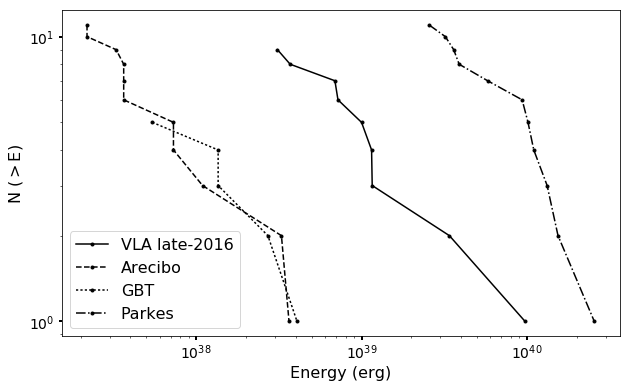

In [11]:
fig = pl.figure(figsize=(10,6))
ax = fig.add_subplot(111)
pl.plot(en0, cnt, 'k.-', label='VLA late-2016')
pl.plot(en_aom, cnt_aom, 'k.--', label='Arecibo')
pl.plot(en_gbt, cnt_gbt, 'k.:', label='GBT')
pl.plot(en_parkes, cnt_parkes, 'k.-.', label='Parkes')
pl.loglog()
#pl.xlim(elim, 1.1e40)
#pl.ylim(0.5, 20)
pl.xlabel('Energy (erg)', fontsize=16)
pl.ylabel('N ($>$E)', fontsize=16)
pl.legend(fontsize=16)
xt = pl.setp(ax.get_xticklabels(), fontsize=14)
yt = pl.setp(ax.get_yticklabels(), fontsize=14)
ax.xaxis.set_tick_params(width=2, color='k')
ax.yaxis.set_tick_params(width=2, color='k')